In [92]:
import sklearn as sk
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [129]:
import pandas as pd
import numpy as np 


class NeuralNetwork:
    """
    Layers: an Integer value representing the total number of hidden layers in the network (input and output layers are extra)
    Nodes: an integer array of size [0,..,Layers+1] containing the dimensions of the neural network. 
    Nodes[0] shall represent the input size (typically, 50), Nodes[Layers+1] shall represent the number of output nodes (typically, 1). 
    All other values Nodes[i] represent the number of nodes in hidden layer i.

    NNodes: a possible alternative to the Nodes parameter for situations where you want each hidden layer of the neural network to be of the same size. 
    In this case, the size of the output layer is assumed to be 1, and the size of the input layer can be inferred from the dataset.

    Activations: an array of size [0,..,Layers+1] (for the sake of compatibility) in which Activations[0] and Activations[Layers+1] are not used, while all other Activations[i] values are labels indicating the activation function used in layer i. 
    This allows you to build neural networks with different activation functions in each layer.
    """
    def __init__(self,Nodes,Activations):



        self.Layers = len(Nodes) - 2
        self.Nodes = Nodes
        self.Activations = Activations
        self.parameter_dict ={}
        self.rate = 0.001

    def initialize_net(self):
        '''
        parameter dict format:
        layer: {w,h,z,delta, activation}
        '''
        parameter_dict = {k: {'w':0, 'h':0, 'z':0, 'bias':0,
                              'delta':0, 'activation':0, 'gradient':0, 'g_bias':0} 
                          for k in range(len(self.Nodes))}
        
        for i in range(1,len(self.Nodes)):
            
            h = np.matrix(np.random.randn(self.Nodes[i]), dtype='float32')
            w = np.matrix(np.random.randn((self.Nodes[i-1]),(self.Nodes[i])), dtype='float32')
            z = np.matrix(np.zeros(self.Nodes[i]), dtype='float32')
            bias = np.matrix(np.random.randn(self.Nodes[i]), dtype='float32')
            delta = np.matrix(np.random.randn(self.Nodes[i]), dtype='float32')
            gradient = np.matrix(np.zeros((self.Nodes[i-1],self.Nodes[i])), dtype='float32')
            g_bias = np.matrix(np.zeros(self.Nodes[i]), dtype='float32')
            activation = self.Activations[i-1]

            parameter_dict[i] = {'w':w, 'h':h, 'z':z, 'bias':bias, 
                                 'delta':delta, 'activation':activation, 
                                 'gradient':gradient, 'g_bias':g_bias}
            
        parameter_dict['y_hat'] = np.random.randint(100000,size =1)[0]
        self.parameter_dict = parameter_dict
        return parameter_dict
    
    def activate(self, z,activation='relu'):
        if activation =='relu':
            if z > 0:
                return z
            else:
                return 0
        if activation == 'sigmoid':
            return (1/(1+np.e** -z))
        
    def activate_prime(self, z, activation='relu'):
        if activation == 'relu':
            if z > 0:
                return 1
            return 0
        
    def forward_propogate(self,data):
        self.parameter_dict[0]['h'] = np.matrix(data)
        for i in range(1,len(self.Nodes)-1):
            #new z value calculated by multiplying node weights and adding bias 
            newz = np.matrix(np.matmul(self.parameter_dict[i-1]['h'],self.parameter_dict[i]['w'])) + self.parameter_dict[i]['bias']
            newh = np.matrix(np.apply_along_axis(self.activate,0,newz))
            self.parameter_dict[i]['z'] = newz
            self.parameter_dict[i]['h'] = newh
        self.parameter_dict['y_hat'] = np.asscalar(np.matmul(self.parameter_dict[len(self.Nodes)-2]['h'],
                                                             self.parameter_dict[len(self.Nodes)-1]['w']))

        return self.parameter_dict['y_hat']

    def calculate_deltas(self,true):
        """
        true: the value of the true y-value
        assumes that all the entries in the dictionary are np.array where applicable
        assumes weights matrix for w_ij appears as j being constant across rows and i across cols
        e.g. [[w11,w21],[w12,w22]] 
        """
        # calculate sum of dervatives of cost
        error = self.parameter_dict["y_hat"] - true
        # last layer d (indexing is correct?)
        # get Zs from the last layer as well
        # error * g'(z)
        self.parameter_dict[len(self.Nodes) - 1]["delta"] = np.matrix(error)
        # last layer is special case, now loop through all the previous layers to calculate sets of deltas
        # from the second to last layer to the first layer – backwards

        for i in range(len(self.Nodes) - 2,0,-1):
            # delta = weights.T x diag(g'(z)) x delta[i+1]
            # extra Ts are just making things into column vectors
            # add the intercept into g_prime
            #print(i)
            g_prime_layer = np.apply_along_axis(self.activate_prime,0,self.parameter_dict[i]["z"])

            self.parameter_dict[i]["delta"] = np.matmul(self.parameter_dict[i + 1]["delta"],
                                                        np.matmul(self.parameter_dict[i + 1]["w"].T,
                                                                  np.matrix(np.diag(g_prime_layer))))
         
    def update_gradient(self):
        for l in range(len(self.Nodes) - 1, 0, -1):
            self.parameter_dict[l]['g_bias'] += self.parameter_dict[l]['delta']
            self.parameter_dict[l]['gradient'] += np.dot(self.parameter_dict[l - 1]['h'].T, 
                                                                     self.parameter_dict[l]['delta'])

    def walk_gradient(self):
        for l in range(len(self.Nodes) - 1, 0, -1):
            self.parameter_dict[l]['bias'] -= self.rate * self.parameter_dict[l]['g_bias']
            self.parameter_dict[l]['g_bias'] = 0 * self.parameter_dict[l]['g_bias']
            
            self.parameter_dict[l]['w'] -= self.rate * self.parameter_dict[l]['gradient']
            self.parameter_dict[l]['gradient'] = 0 * self.parameter_dict[l]['gradient']
            
    def train(self,data,y,batch_size = 100, epochs = 8):

        self.initialize_net()
        for i in range(epochs * len(data)):
            idx = i % len(data)
            
            if i % batch_size == 0 and i != 0:
                self.walk_gradient()
                
            self.forward_propogate(data[idx,:])
            self.calculate_deltas(y[idx])
            self.update_gradient()
    
    def predict(self, test_data):
        preds = []
        for i in range(len(test_data)):
            self.forward_propogate(test_data[i])
            preds.append(self.parameter_dict['y_hat'])
        return preds

In [77]:
nodes = [3,2,2,1]
activation = ['relu','relu','relu','relu']
net = NeuralNetwork(nodes,activation)
net.initialize_net()
net.parameter_dict[1]['w'] = np.matrix([[3.,1.],[2.,0],[1,-1]])
net.parameter_dict[2]['w'] = np.matrix([[-2.,4],[0,-3.]])
net.parameter_dict[3]['w'] = np.matrix([[5.],[2]])
net.parameter_dict[1]['bias'] = np.matrix([[0.,0]])
net.parameter_dict[2]['bias'] = np.matrix([[0.,0]])
net.parameter_dict[3]['bias'] = np.matrix([[0.]])
data = np.matrix([1,-2,2])

In [78]:
net.forward_propogate(data)

8.0

In [79]:
net.calculate_deltas(3)

In [80]:
net.update_gradient()

In [81]:
net.walk_gradient()

In [109]:
boston,prices = datasets.load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
boston, prices, test_size=0.2, random_state=42)

scaler = preprocessing.StandardScaler( )
X_train = scaler.fit_transform( X_train )
X_test = scaler.fit_transform( X_test )

In [139]:
nodes = [13,10,10,1]
net = NeuralNetwork(nodes, activation)

net.train(X_train,y_train,batch_size=1, epochs=10)

In [136]:
y_pred = net.predict(X_test)
#y_pred

Text(0.5, 1.0, 'Real vs Predicted Housing Prices')

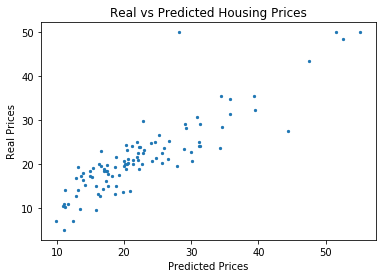

In [137]:
plt.scatter( y_pred, y_test, s=5 )
plt.xlabel( "Predicted Prices")
plt.ylabel( "Real Prices")
plt.title( "Real vs Predicted Housing Prices")

In [138]:
score = metrics.mean_squared_error( y_pred, y_test )
print('MSE: {0:f}'.format(score) )

MSE: 21.447466
